In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['font.family'] = 'NanumGothic'
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

2023-08-24 11:43:25.014636: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 11:43:25.073788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 11:43:25.075102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 11:43:26.087911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_excel('./수입안정성검사결과.xlsx',engine='openpyxl')

In [4]:
df.head(3)

,수입신고번호,란번호,신고품명,거래품명,신고세관부호,신고과코드,검사일자,수입안전성검사결과코드,수입안전성검사결과상세내역,수입검사결과코드,조치내용
0,4131518937032M,1,OTHER,FOOD HYLEYS SLIM TEA ASSORTED TEA COLLECTION 4...,40,94,20181124,B,NaN,NaN,중점감시 수입식품 통관보류
1,4176718109321M,2,STAINLESS SCRAP,STAINLESS SCRAP,20,09,20180911,A,NaN,NaN,안전인증기관평가의뢰
2,4053418501155M,1,OTHER LIGHTING FITTINGS PARTS,LED LIGHTING PARTS,20,11,20180911,A,NaN,NaN,기타 구비서류 징구


In [5]:
len(df)

71636

In [6]:
df['수입안전성검사결과코드'].value_counts()

A    6114
C    2703
B     768
F     596
D     201
H      61
G      10
E       3
Name: 수입안전성검사결과코드, dtype: int64

In [8]:
ddf = df[df['수입안전성검사결과코드'] =='H'].copy()

In [10]:
ddf['조치내용'] = ddf['조치내용'].fillna('')
ddf['total_text'] = ddf['조치내용']
ddf['total_text'] = ddf['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","", regex=True)
ddf['total_text'] = ddf['total_text'].str.replace("ㅇ","", regex=True)

In [12]:
# 결측행 삭제
ddf.dropna(axis=0)

,수입신고번호,란번호,신고품명,거래품명,신고세관부호,신고과코드,검사일자,수입안전성검사결과코드,수입안전성검사결과상세내역,수입검사결과코드,조치내용,total_text


In [13]:
ddf.head(5)

,수입신고번호,란번호,신고품명,거래품명,신고세관부호,신고과코드,검사일자,수입안전성검사결과코드,수입안전성검사결과상세내역,수입검사결과코드,조치내용,total_text
757,1334118A20081M,1,OTHER,DIET PRODUCTSHYDROXYCUT HARDCORE NEXT GEN INTE...,40,58,20190503,H,NaN,NaN,세관장확인대상으로 변경(동일세번),세관장확인대상으로 변경동일세번
3212,4111919009889M,1,OTHER,HYDROXYCUT SX7 REVOLUTION ULTIMATE THERMOGENIC...,40,94,20190218,H,NaN,NaN,중점감시 수입식품 통관보류,중점감시 수입식품 통관보류
3656,1235619154077M,5,COMPUTER,COMPUTER,40,80,20190215,H,NaN,NaN,수입요건 정정(모델명 : D09M->D13M),수입요건 정정모델명 DMDM
3942,4389219700074M,2,NOTEBOOKS,NOTEBOOKS,30,83,20190211,H,NaN,NaN,고세율 품목으로 세번변경(HS4단위 이상),고세율 품목으로 세번변경HS단위 이상
3943,4389219700074M,3,NOTEBOOKS,NOTEBOOKS,30,83,20190211,H,NaN,NaN,고세율 품목으로 세번변경(HS4단위 이상),고세율 품목으로 세번변경HS단위 이상


In [14]:
# 폰트 설치 여부 및 경로 확인
# import matplotlib.font_manager as fm
# sys_font = fm.findSystemFonts()
# [f for f in sys_font if 'Nanum' in f]

In [15]:
def wordcloud(grp, model):
    g1 = ddf[ddf[model] == grp].groupby('total_text')['total_text'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row in enumerate(g1.iterrows()):
        g1_ditc[row[1]['total_text']] = row[1]['cnt']

    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # 한글 글씨체 설정
        background_color='white', # 배경색은 흰색으로 
        colormap='Reds', # 글씨색은 빨간색으로
        mask=None, # 워드클라우드 모양 설정
        width=800, height=800 # 이미지 크기 설정
    ).generate_from_frequencies(g1_ditc)
    
    # 사이즈 설정 및 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.savefig(str(model)+ '_' + str(grp) +'.png', facecolor='#eeeeee')
    plt.show()

    print('---' * 30)

In [16]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(ddf['total_text'].fillna('')): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

100%|██████████| 61/61 [00:04<00:00, 12.74it/s]


In [17]:
ddf['nouns'] = noun_list

In [18]:
# Word2Vec 학습
model = Word2Vec(sentences = noun_list, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 0)

In [19]:
# ddf['nouns']의 값을 하나씩 꺼내서 word2vec 벡터화하고 문장의 단어 벡터를 평균내서 결과를 반환
vectors = ddf['nouns'].apply(lambda x: np.array(np.mean([model.wv[w] for w in x if w in model.wv], axis=0)))

ddf['pad_vectors'] = vectors

In [20]:
# NaN 값을 제거합니다.
ddf = ddf.dropna(subset=['pad_vectors'])

In [21]:
# 비원진 값을 0으로 대입하여 최대크기(100차원) 벡터길이로 모든 자료를 맞춥니다.
max_len = max([len(v) for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)])
pad_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)]
ddf['pad_vectors'] = pad_vectors

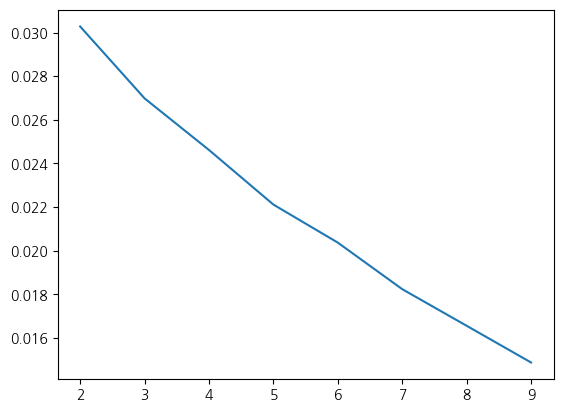

In [22]:
# 군집수 시뮬레이션
itr = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    km.fit(pad_vectors)
    itr.append(km.inertia_)
    
plt.plot(range(2,10), itr)
plt.show()

In [23]:
# 2차원 배열 형태로 변환합니다.
X = np.array(pad_vectors)
# KMeans 알고리즘을 적용합니다.
kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

# 군집 결과를 확인합니다.
labels = kmeans.labels_
ddf['kmeans'] = labels

In [24]:
ddf['kmeans'].value_counts()

0    27
1    27
2     7
Name: kmeans, dtype: int64

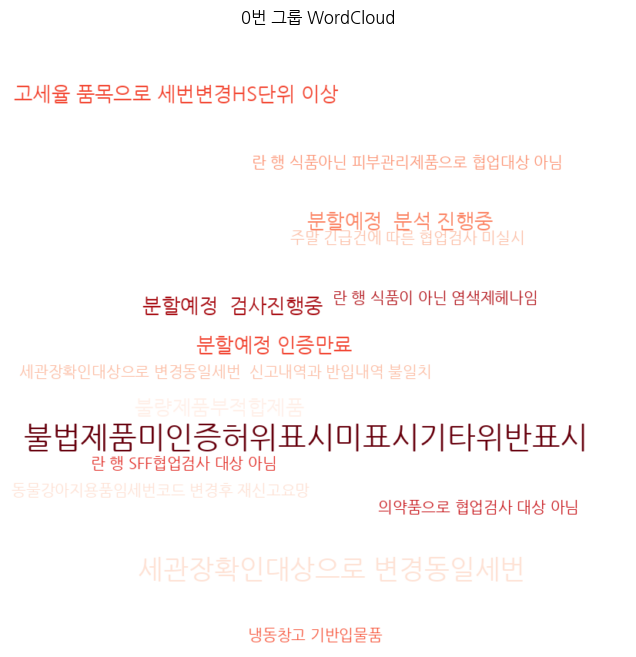

------------------------------------------------------------------------------------------


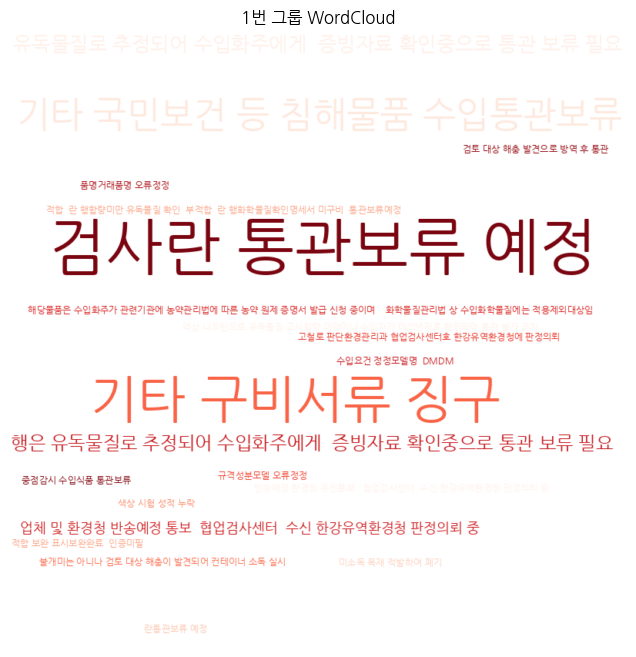

------------------------------------------------------------------------------------------


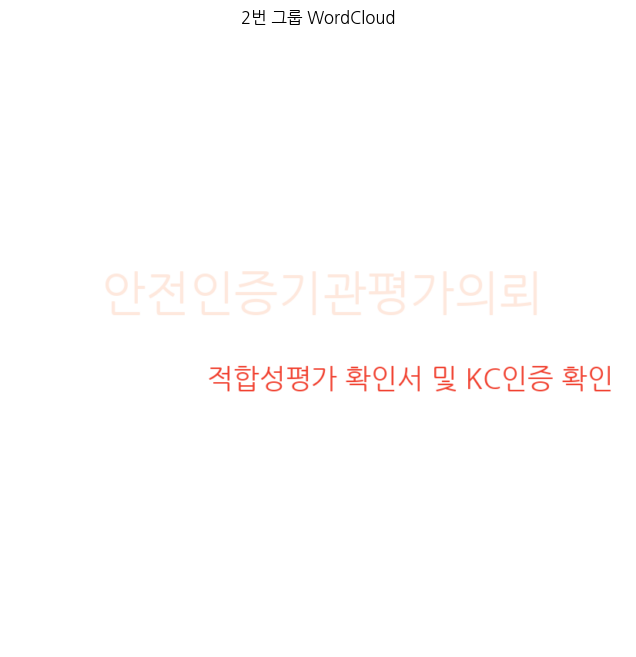

------------------------------------------------------------------------------------------


In [46]:
# 그룹별 워드클라우드 시각화
for i in range(ddf['kmeans'].max()+1):
    wordcloud(i,'kmeans')

In [39]:
# DBSCAN : 인접한 데이터를 클러스터링

X = np.array(pad_vectors) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=0.001,min_samples=3)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(X)
result = model.fit_predict(X)

In [40]:
ddf['dbscan'] = result

In [41]:
np.unique(ddf['dbscan'])

array([-1,  0,  1,  2,  3])

In [42]:
ddf['dbscan'].value_counts()

-1    43
 1     6
 2     5
 0     4
 3     3
Name: dbscan, dtype: int64

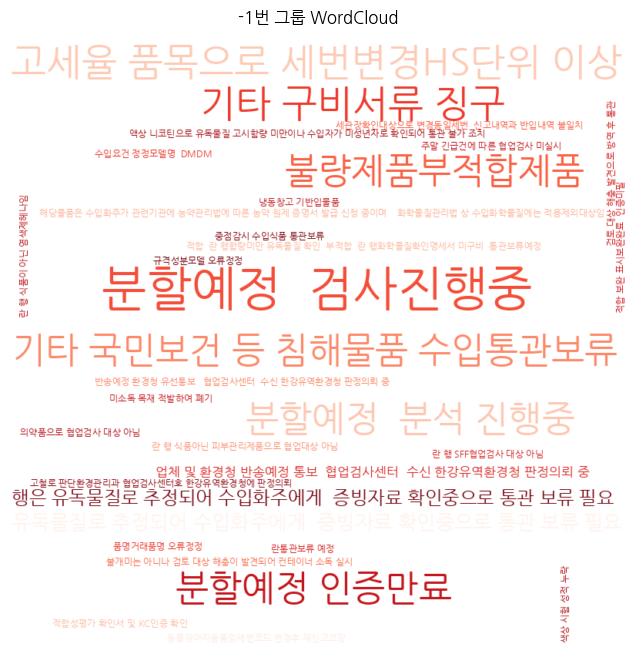

------------------------------------------------------------------------------------------


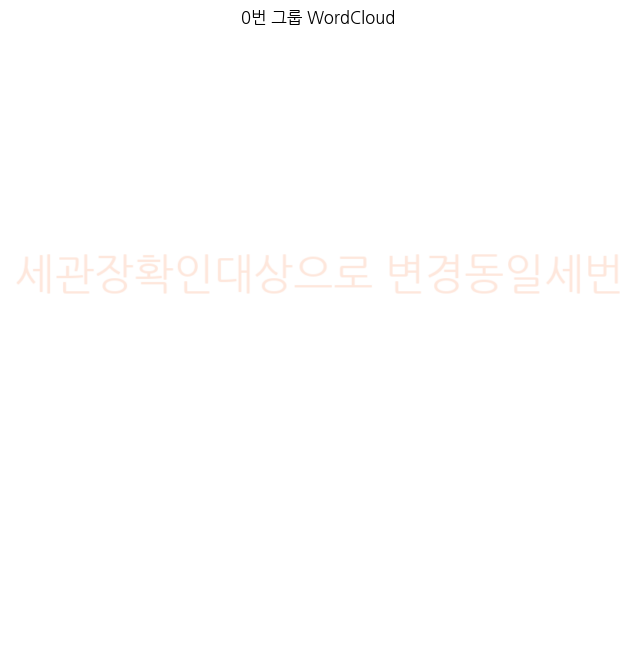

------------------------------------------------------------------------------------------


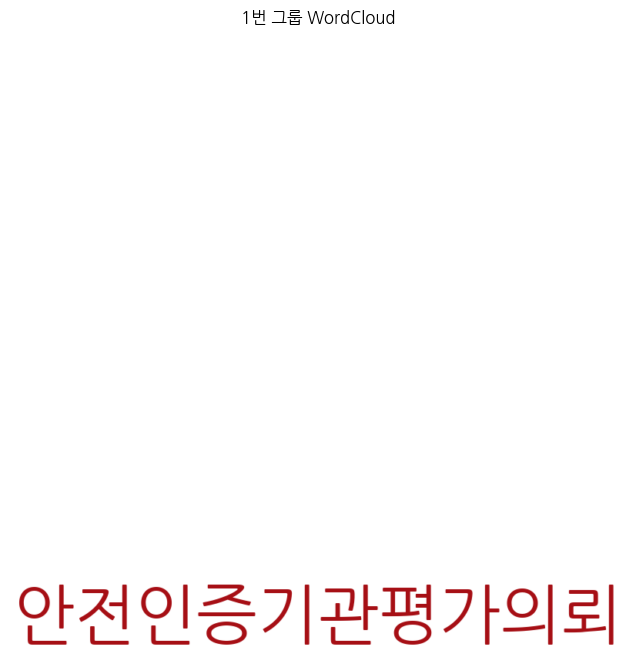

------------------------------------------------------------------------------------------


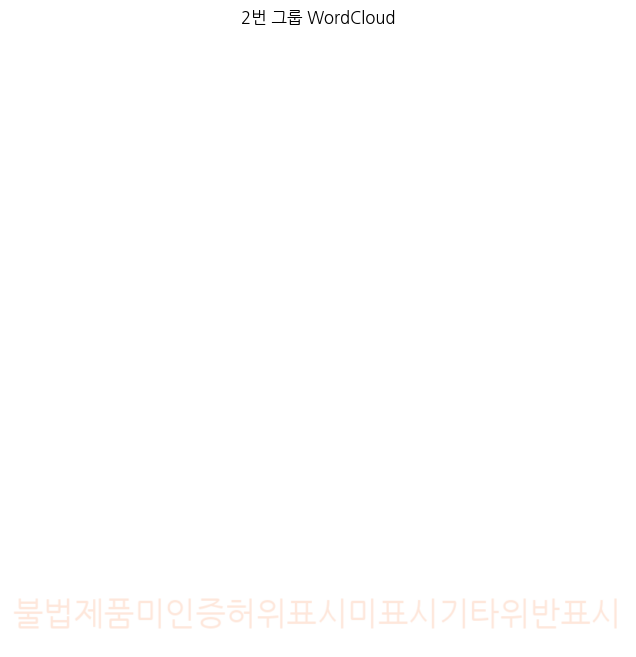

------------------------------------------------------------------------------------------


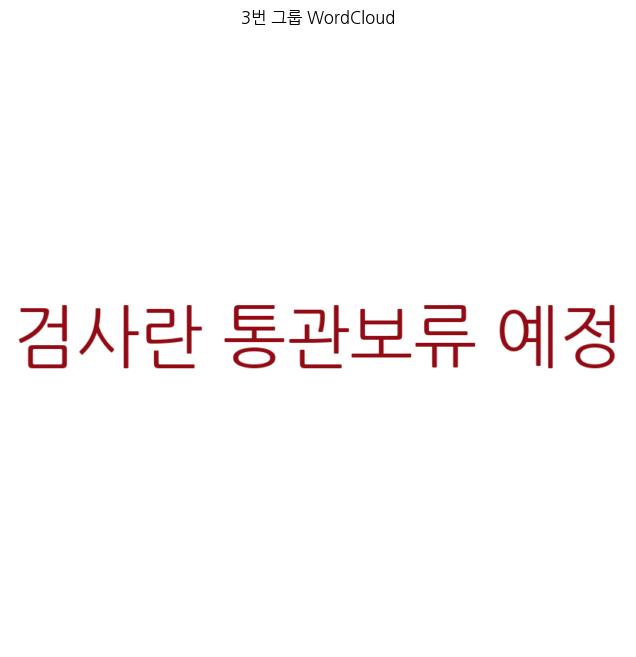

------------------------------------------------------------------------------------------


In [45]:
# 그룹별 워드클라우드 시각화
for i in range(-1, ddf['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [44]:
ddf.to_excel('./수입안정성검사결과_비지도결과.xlsx',index=False,engine='openpyxl')